In [1]:
! pip install mlrose
! pip install six
! pip install mlrose_hiive
! pip install networkx
! pip install datacleaner
# ! pip install google.colab
# from google.colab import drive
# ! pip install pickle
# import pickle

import networkx as nx
import six
import sys
sys.modules['sklearn.externals.six'] = six
import string
import numpy as np
import pandas as pd
#import plotly.express as px
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score, validation_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
import mlrose
import mlrose_hiive
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator
from mlrose_hiive import RHCRunner, SARunner, GARunner, MIMICRunner, NNGSRunner, NeuralNetwork
from datacleaner import autoclean
from sklearn.metrics import f1_score
# import time


Plotting Discrete Optimization Problem

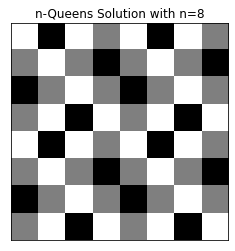

In [ ]:
def plot_n_queens_solution(board):
    n = board.shape[0]
    board_image = np.zeros((n, n))
    board_image[::2, 1::2] = 1
    board_image[1::2, ::2] = 1
    queens = np.argwhere(board)
    for r, c in queens:
        board_image[r, c] = 2
    fig, ax = plt.subplots()
    ax.imshow(board_image, cmap='binary')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"n-Queens Solution with n={n}")
    plt.show()

board = np.array([[False, True, False, False, False, False, False, False],
                  [False, False, False, True, False, False, False, True],
                  [True, False, False, False, True, False, False, False],
                  [False, False, True, False, False, False, True, False],
                  [False, True, False, False, False, True, False, False],
                  [False, False, False, True, False, False, False, True],
                  [True, False, False, False, True, False, False, False],
                  [False, False, True, False, False, False, True, False]
                  ])
plot_n_queens_solution(board)

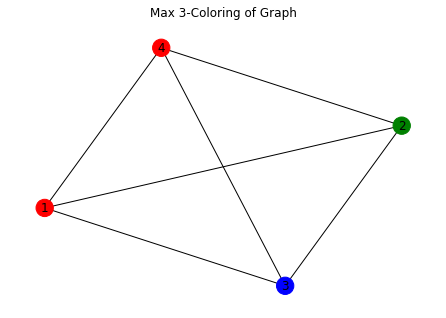

In [ ]:

def plot_max_k_color_solution(graph, k, color_map):
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, node_color=color_map, with_labels=True)
    plt.title(f"Max {k}-Coloring of Graph")
    plt.show()

graph = nx.Graph()
graph.add_edges_from([(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)])
color_map = ['r', 'g', 'b', 'r']
k = 3
plot_max_k_color_solution(graph, k, color_map)


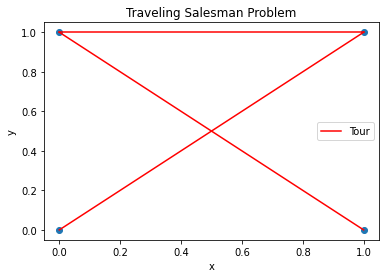

In [ ]:
def plot_tsp(cities, tour):
    fig, ax = plt.subplots()
    ax.scatter(cities[:, 0], cities[:, 1])
    for i in range(len(tour)-1):
        ax.plot(cities[tour[i:i+2], 0], cities[tour[i:i+2], 1], 'r')
    ax.plot(cities[tour[-1], 0], cities[tour[-1], 1], 'r', label='Tour')
    ax.legend()
    ax.set_title("Traveling Salesman Problem")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()

cities = np.array([[0, 0], [0, 1], [1, 1], [1, 0]])
tour = [0, 2, 1, 3]
plot_tsp(cities, tour)

In [67]:
def get_algoritm_run_stats(algo_name, problem):
    if algo_name == 'RHC':
        algo = RHCRunner(problem=problem,
                           experiment_name="Random Hill Climb",
                           seed=0,
                           iteration_list=2 ** np.arange(10),
                           max_attempts=1000,
                           restart_list=[10])
    elif algo_name == 'SA':
        algo = SARunner(problem=problem,
                         experiment_name="Simulated Annealing",
                         seed=13,
                         iteration_list=2 ** np.arange(10),
                         max_attempts=1000,
                         temperature_list=[0.1, 0.5, 0.75, 1.0, 2.0, 5.0])
    elif algo_name == 'GA':
        algo = GARunner(problem=problem,
                         experiment_name="Genetic Algorithm",
                         seed=None,
                         iteration_list=2 ** np.arange(10),
                         max_attempts=1000,
                         population_sizes=[10, 20, 50, 100, 200],
                         mutation_rates=[0.01, 0.1, 0.2, 0.5])
    elif algo_name == 'MIMIC':
        algo = MIMICRunner(problem=problem,
                           experiment_name="MIMIC",
                           seed=None,
                           iteration_list=2 ** np.arange(10),
                           population_sizes=[50, 100, 200],
                           max_attempts=1000,
                           keep_percent_list=[0.05, 0.1, 0.2, 0.5],
                           use_fast_mimic=True)
    run_statistics, run_curves = algo.run()
    return run_statistics, run_curves


def get_best_run_curve(run_curves):
    runs_with_min_fitness = run_curves[run_curves['Fitness'] == run_curves['Fitness'].min()]
    best_run_curve = runs_with_min_fitness[runs_with_min_fitness['FEvals'] == runs_with_min_fitness['FEvals'].min()]
    return best_run_curve


def get_best_run_statistics(algo_name, best_run_curve, run_statistics):
    if algo_name == 'RHC':
        best_stats = run_statistics[(run_statistics['current_restart'] == best_run_curve['current_restart'].iloc()[0])]
    elif algo_name == 'SA':
        best_stats = run_statistics[(run_statistics['Temperature'] == best_run_curve['Temperature'].iloc()[0])]
    elif algo_name == 'GA':
        best_stats = run_statistics[(run_statistics['Mutation Rate'] == best_run_curve['Mutation Rate'].iloc()[0]) & (run_statistics['Population Size'] == best_run_curve['Population Size'].iloc()[0])]
    elif algo_name == 'MIMIC':
        best_stats = run_statistics[(run_statistics['Keep Percent'] == best_run_curve['Keep Percent'].iloc()[0]) & (run_statistics['Population Size'] == best_run_curve['Population Size'].iloc()[0])]
    best_stats['Algorithm'] = algo_name
    return best_stats


def get_fitness_score(problem_name, fitness):
    if problem_name == 'n_queens':
        fitness_score = 28 - fitness
    elif problem_name == 'max_k':
        fitness_score = 19 - fitness
    elif problem_name == 'tsp':
        fitness_score = float(1) / fitness
    return fitness_score



def plot_to_compare_performance(problem_name, results):
    fig, ax = plt.subplots()

  # plot each algorithm separately
    for algorithm, group in results.groupby("Algorithm"):
        ax.plot(group["Iteration"], group["Time"], label=algorithm)

  # set labels and title
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Time")
    ax.set_title(problem_name + " Computation Time")

  # add legend
    ax.legend()

  # show plot
    plt.show()

    fig, ax = plt.subplots()
  
    for algorithm, group in results.groupby("Algorithm"):
        ax.plot(group["Iteration"], group["Fitness"], label=algorithm)

  # set labels and title
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Fitness")
    ax.set_title(problem_name + " Fitness Score")

  # add legend
    ax.legend()

  # show plot
    plt.show()





In [42]:
#set problem
n_queens = QueensGenerator().generate(seed=123, size=8)
max_k = MaxKColorGenerator().generate(seed=123, number_of_nodes=10, max_connections_per_node=3, max_colors=3)
tsp = TSPGenerator().generate(seed=123, number_of_cities=20)

In [44]:
problem_names = ['n_queens', 'max_k', 'tsp']
problems = [n_queens, max_k, tsp]
algos = ['RHC', 'SA', 'GA', 'MIMIC']

problem_dict = {}

for index in range(len(problem_names)):
    pn = problem_names[index]
    p = problems[index]
    problem_dict[pn] = {}
  #problem_dict[pn]['problem_name'] = pn
    problem_dict[pn]['problem_info'] = p
    problem_dict[pn]['algo_info'] = {}

    for a_index in range(len(algos)):
        a = algos[a_index]
        print('='*50)
        print({'problem_name': pn, 'algo_name': a})
        problem_dict[pn]['algo_info'][a] = {}
        print('run stats')
        problem_dict[pn]['algo_info'][a]['run_statistics'], problem_dict[pn]['algo_info'][a]['run_curves'] =  get_algoritm_run_stats(a, p)
        print('best run curve')
        problem_dict[pn]['algo_info'][a]['best_run_curve'] = get_best_run_curve(problem_dict[pn]['algo_info'][a]['run_curves'])
        print('best stats')
        problem_dict[pn]['algo_info'][a]['best_stats_df'] = get_best_run_statistics(a, problem_dict[pn]['algo_info'][a]['best_run_curve'], problem_dict[pn]['algo_info'][a]['run_statistics'])
#         print('fitness score')
#         problem_dict[pn]['algo_info'][a]['best_stats_df'] = get_fitness_score(pn, problem_dict[pn]['algo_info'][a]['best_stats_df'])




{'problem_name': 'n_queens', 'algo_name': 'RHC'}
run stats
best run curve
best stats
{'problem_name': 'n_queens', 'algo_name': 'SA'}
run stats
best run curve
best stats
{'problem_name': 'n_queens', 'algo_name': 'GA'}
run stats
best run curve
best stats
{'problem_name': 'n_queens', 'algo_name': 'MIMIC'}
run stats
best run curve
best stats
{'problem_name': 'max_k', 'algo_name': 'RHC'}
run stats
best run curve
best stats
{'problem_name': 'max_k', 'algo_name': 'SA'}
run stats
best run curve
best stats
{'problem_name': 'max_k', 'algo_name': 'GA'}
run stats
best run curve
best stats
{'problem_name': 'max_k', 'algo_name': 'MIMIC'}
run stats
best run curve
best stats
{'problem_name': 'tsp', 'algo_name': 'RHC'}
run stats
best run curve
best stats
{'problem_name': 'tsp', 'algo_name': 'SA'}
run stats
best run curve
best stats
{'problem_name': 'tsp', 'algo_name': 'GA'}
run stats
best run curve
best stats
{'problem_name': 'tsp', 'algo_name': 'MIMIC'}
run stats
best run curve
best stats


In [62]:
for index in range(len(problem_names)):
    pn = problem_names[index]
    for a_index in range(len(algos)):
        a = algos[a_index]
        problem_dict[pn]['algo_info'][a]['best_stats_df']['problem_name'] = pn
        problem_dict[pn]['algo_info'][a]['best_stats_df']['fitness_score'] = get_fitness_score(pn, problem_dict[pn]['algo_info'][a]['best_stats_df']['Fitness'])    

In [60]:
problem_dict['n_queens']['algo_info']['RHC']

{'run_statistics':      Iteration  Fitness  FEvals      Time                     State  Restarts  \
 0            0      4.0       0  0.002447  [1, 3, 5, 2, 4, 7, 6, 0]        10   
 1            1      4.0       1  0.009295  [1, 3, 5, 2, 4, 7, 6, 0]        10   
 2            2      4.0       2  0.012656  [1, 3, 5, 2, 4, 7, 6, 0]        10   
 3            4      4.0       4  0.015352  [1, 3, 5, 2, 4, 7, 6, 0]        10   
 4            8      3.0       9  0.017860  [1, 3, 5, 2, 4, 1, 6, 0]        10   
 ..         ...      ...     ...       ...                       ...       ...   
 116         32      3.0    5193  6.713020  [5, 6, 4, 7, 2, 6, 3, 1]        10   
 117         64      2.0    5226  6.793157  [0, 6, 4, 7, 2, 6, 3, 1]        10   
 118        128      2.0    5290  6.946740  [0, 6, 4, 7, 2, 6, 3, 1]        10   
 119        256      2.0    5418  7.249706  [0, 6, 4, 7, 2, 6, 3, 1]        10   
 120        512      2.0    5674  7.869042  [0, 6, 4, 7, 2, 6, 3, 1]        10  

In [63]:
relevant_columns = ['problem_name', 'Algorithm', 'Iteration', 'Time', 'Fitness', 'FEvals']
consolidated_algo_problem_df = pd.DataFrame()
for index in range(len(problem_names)):
    pn = problem_names[index]
    for a_index in range(len(algos)):
        a = algos[a_index]
        df = problem_dict[pn]['algo_info'][a]['best_stats_df'][relevant_columns]
        df['performance'] = df.apply(lambda x: get_fitness_score(x.problem_name, x.Fitness), axis=1)
        #print(df.shape)
        if df.shape != (0,0):
            consolidated_algo_problem_df = pd.concat([consolidated_algo_problem_df,df])
        else:
            consolidated_algo_problem_df = df

In [69]:
consolidated_algo_problem_df[consolidated_algo_problem_df['problem_name'] == 'n_queens']

,problem_name,Algorithm,Iteration,Time,Fitness,FEvals,performance
11,n_queens,RHC,0,0.167898,7.0,514,7.0
12,n_queens,RHC,1,0.169555,7.0,515,7.0
13,n_queens,RHC,2,0.171192,7.0,516,7.0
14,n_queens,RHC,4,0.173334,5.0,519,5.0
15,n_queens,RHC,8,0.176227,4.0,524,4.0
16,n_queens,RHC,16,0.180466,4.0,532,4.0
17,n_queens,RHC,32,0.187752,4.0,548,4.0
18,n_queens,RHC,64,0.201522,3.0,581,3.0
19,n_queens,RHC,128,0.230525,1.0,647,1.0
20,n_queens,RHC,256,0.290476,1.0,775,1.0


Plots for Problem type: n_queens


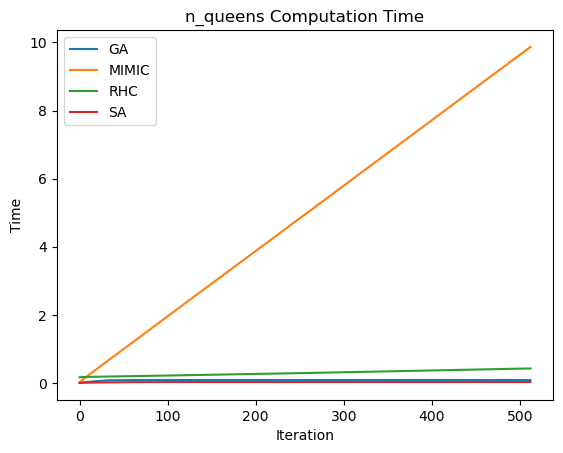

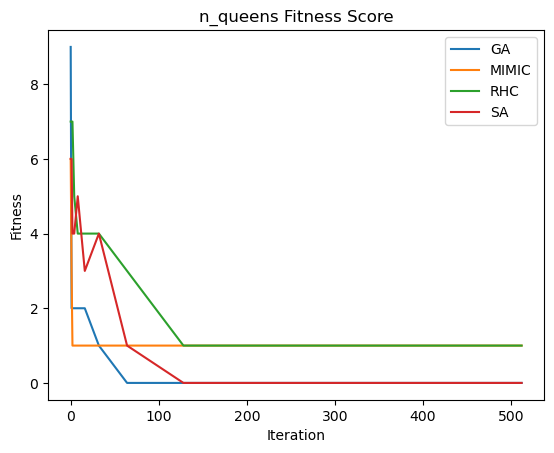

Plots for Problem type: max_k


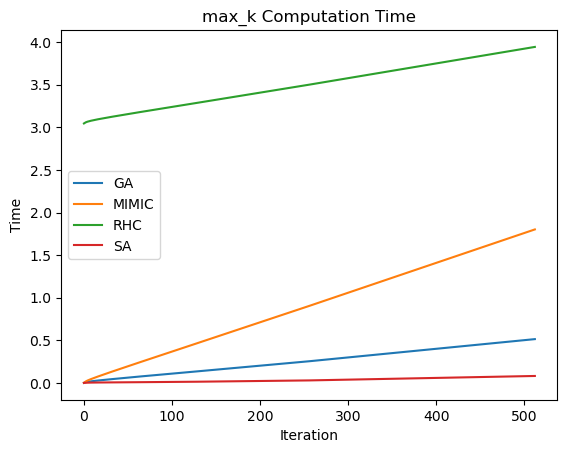

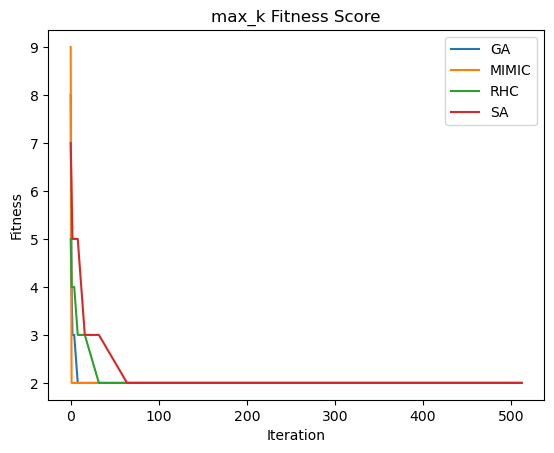

Plots for Problem type: tsp


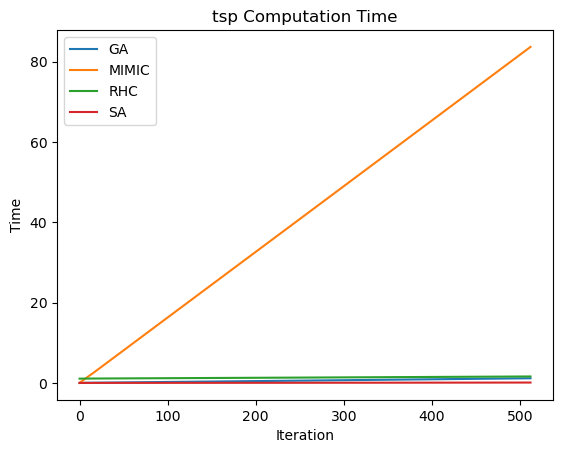

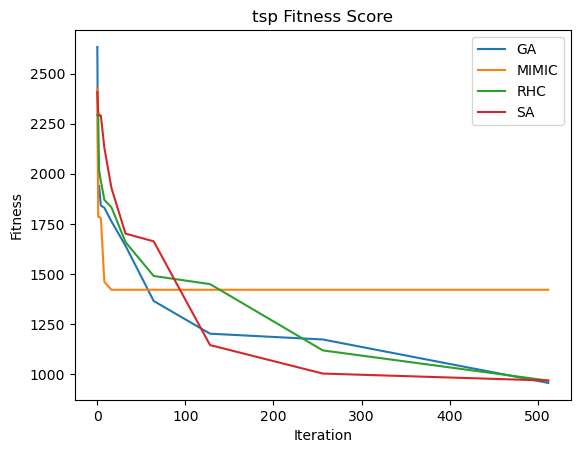

In [68]:
for index in range(len(problem_names)):
    pn = problem_names[index]
    res = consolidated_algo_problem_df[consolidated_algo_problem_df['problem_name'] == pn]
    print('Plots for Problem type: ' + pn)
    plot_to_compare_performance(pn, res)
#problem_dict['n_queens']['algo_info']['SA']['best_stats_df'].columns

In [ ]:
#neural network

In [2]:
# from google.colab import files
# import io
# import pandas as pd
# uploaded = files.upload()
# diabetes = pd.read_csv(io.BytesIO(uploaded['diabetes.csv']))
# Dataset is now stored in a Pandas Dataframe
diabetes = pd.read_csv('diabetes.csv')

In [3]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
def drop_duplicate_rows(df):
    return df.drop_duplicates(keep='first')

def normalize_features(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
    return df_scaled

def split_dataset(df, target_col):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
    X_train, X_test = train_df.drop(target_col, axis=1), test_df.drop(target_col, axis=1)
    y_train, y_test = train_df[target_col], test_df[target_col]
    return X_train, y_train, X_test, y_test

diabetes = autoclean(diabetes)
diabetes = drop_duplicate_rows(diabetes)
diabetes = normalize_features(diabetes)
X_train, y_train,  X_test, y_test, = split_dataset(diabetes, 'Outcome')

In [69]:
nn_algo_name_object_map = {'gradient_descent': 'gradient_descent',
                           'RHC': 'random_hill_climb',
                           'SA': 'simulated_annealing',
                           'GA' : 'genetic_alg'
                           }
# nn_grid_search_parameters = {
#     'max_iters': [1000],                         
#     'learning_rate': [1e-1, 1e-2],                      
#     'activation': [mlrose_hiive.relu],            
#     'restarts': [10],
# }


# def nn_builder(algo_name, X_train, y_train, X_test, y_test):
#   nn = NNGSRunner(
#     x_train=X_train,
#     y_train=y_train,
#     x_test=X_test,
#     y_test=y_test,
#     experiment_name='nn_experiment_' + algo_name,
#     algorithm=nn_algo_name_object_map[algo_name],
#     grid_search_parameters=nn_grid_search_parameters,
#     iteration_list=[1, 10, 50, 100, 500, 1000],
#     hidden_layer_sizes=[[3]],
#     bias=True,
#     early_stopping=True,
#     clip_max=5,
#     max_attempts=500,
#     n_jobs=-1,
#     seed=123,
#     output_directory=None
# )
#   return nn
  

def nn_builder(algo_name = 'random_hill_climb', activation_type = 'relu', hidden_nodes_n = 2, learning_rate_n = 0.0001, restarts_n = 0, pop_size_n = 200, schedule_n =  mlrose.GeomDecay()):
    nn_model = mlrose.NeuralNetwork(hidden_nodes = [hidden_nodes_n], activation = activation_type, 
                                 algorithm = algo_name, 
                                 max_iters = 1000, bias = True, is_classifier = True, 
                                 learning_rate = learning_rate_n, early_stopping = True, 
                                 clip_max = 5, max_attempts = 100, random_state = 3, restarts = restarts_n, pop_size = pop_size_n)
    return nn_model


def get_time_curve(nn_model, X, y):
    train_sizes, train_times, test_times = [], [], []
    for frac in np.linspace(0.1, 1.0, 10):
        n = int(frac * len(X))
        X_sub, y_sub = X[:n], y[:n]
        start_time = time.time()
        nn_model.fit(X_sub, y_sub)
        train_time = time.time() - start_time
        train_times.append(train_time)
        start_time = time.time()
        nn_model.predict(X_sub)
        test_time = time.time() - start_time
        test_times.append(test_time)
        train_sizes.append(n)
    return train_sizes, train_times, test_times

def plot_time_curves(algo_train_times, algo_test_times):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    for algo in algo_train_times.keys():
        ax1.plot(algo_train_times[algo][0], algo_train_times[algo][1], 'o-', label=algo)
        ax2.plot(algo_test_times[algo][0], algo_test_times[algo][1], 'o-', label=algo)
    ax1.set_xlabel("Training Size")
    ax1.set_ylabel("Training Time (seconds)")
    ax1.legend(loc="best")
    ax2.set_xlabel("Training Size")
    ax2.set_ylabel("Prediction Time (seconds)")
    ax2.legend(loc="best")
    plt.show()


def plot_learning_curve(models, X_train, y_train):
    """Plot the learning curve for neural network models with the specified optimization algorithms."""
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.ravel()
    for i, (algo_name, nn_model) in enumerate(models.items()):
        nn_model.fit(X_train, y_train)
        train_sizes, train_scores, test_scores = learning_curve(nn_model, X_train, y_train, cv=5, scoring='f1_weighted')
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
        axs[i].plot(train_sizes, train_mean, 'o-', label=f'Training score ({algo_name})')
        axs[i].plot(train_sizes, test_mean, 'o-', label=f'Cross-validation score ({algo_name})')
        axs[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
        axs[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
        axs[i].set_xlabel('Number of training examples')
        axs[i].set_ylabel('Weighted F1 Score')
        axs[i].set_title(f'Learning curves for Neural Network with {algo_name} optimization')
        axs[i].legend(loc='best')
    plt.show()

def plot_generalization_performance(models,X_train, y_train, X_test, y_test):
    scores = {}
    for algo, nn_model in models.items():
        nn_model.fit(X_train, y_train)
        y_pred = nn_model.predict(X_test)
        score = f1_score(y_test, y_pred, average='weighted')
        scores[algo] = score

    fig, ax = plt.subplots(figsize=(8,6))
    ax.bar(scores.keys(), scores.values())
    ax.set_xlabel('Optimization Algorithm')
    ax.set_ylabel('Weighted F1 Score')
    ax.set_title('Generalization Performance of Neural Network Models')
    plt.show()

def plot_loss_vs_iterations(models, x_train, y_train):
    plt.figure(figsize=(8,6))
    for algo, nn_model in models.items():
        nn_model.fit(x_train, y_train)
        fc = nn_model.fitness_curve
        print(fc)
        plt.plot(fc, label=f"{algo} optimization")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs Iterations for Neural Networks with different optimizations')
    plt.legend(loc='best')
    plt.show()
# def get_convergence_data(nn_model, x_train, y_train):
#     """Returns the convergence data for a neural network model with the specified optimization algorithm."""
#     nn_model.fit(x_train, y_train)
#     return nn_model.fitness_curve

# def plot_convergence(models, x_train, y_train):
#     """Plot the convergence of neural network models with the specified optimization algorithms."""
#     plt.figure(figsize=(8,6))
#     for algo, nn_model in models.items():
#         train_loss = get_convergence_data(nn_model, x_train, y_train)
#         plt.plot(train_loss, label=f"{algo} optimization")
#     plt.xlabel('Iteration')
#     plt.ylabel('Loss')
#     plt.title('Convergence plot for Neural Networks with different optimizations')
#     plt.legend(loc='best')
#     plt.show()




In [76]:
#nn_weight_algos = ['gradient_descent','random_hill_climb', 'simulated_annealing','genetic_alg']
models = {}
for k, algo in nn_algo_name_object_map.items():
    models[algo] = nn_builder(algo_name = algo, activation_type = 'relu', hidden_nodes_n = 200, learning_rate_n = 0.0001,  restarts_n = 10, pop_size_n = 400, schedule_n =  mlrose.ArithDecay())

In [77]:
models

{'gradient_descent': NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[200],
               learning_rate=0.0001, max_iters=1000, pop_size=400, restarts=10),
 'random_hill_climb': NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[200],
               learning_rate=0.0001, max_iters=1000, pop_size=400, restarts=10),
 'simulated_annealing': NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[200],
               learning_rate=0.0001, max_iters=1000, pop_size=400, restarts=10),
 'genetic_alg': NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[200],
               learning_rate=0.0001, max_iters=1000, pop_size=400, restarts=10)}

In [78]:
sgd_train_sizes, sgd_train_times, sgd_test_times = get_time_curve(models['gradient_descent'], X_train, y_train)
rhc_train_sizes, rhc_train_times, rhc_test_times = get_time_curve(models['random_hill_climb'],  X_train, y_train)
sa_train_sizes, sa_train_times, sa_test_times = get_time_curve(models['simulated_annealing'],  X_train, y_train)
ga_train_sizes, ga_train_times, ga_test_times = get_time_curve(models['genetic_alg'],  X_train, y_train)

algo_train_times = {'gradient_descent': (sgd_train_sizes, sgd_train_times), 'random_hill_climb': (rhc_train_sizes, rhc_train_times), 
                    'simulated_annealing': (sa_train_sizes, sa_train_times), 'genetic_alg': (ga_train_sizes, ga_train_times)}
algo_test_times = {'gradient_descent': (sgd_train_sizes, sgd_test_times), 'random_hill_climb': (rhc_train_sizes, rhc_test_times), 
                   'simulated_annealing': (sa_train_sizes, sa_test_times), 'genetic_alg': (ga_train_sizes, ga_test_times)}

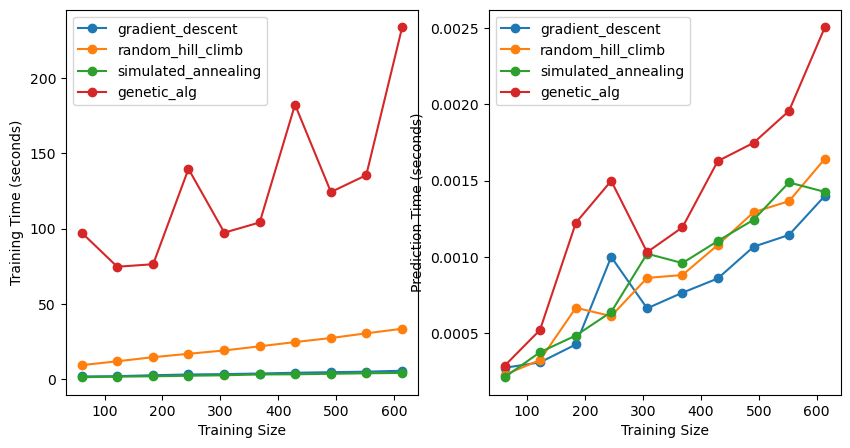

In [79]:
plot_time_curves(algo_train_times, algo_test_times)

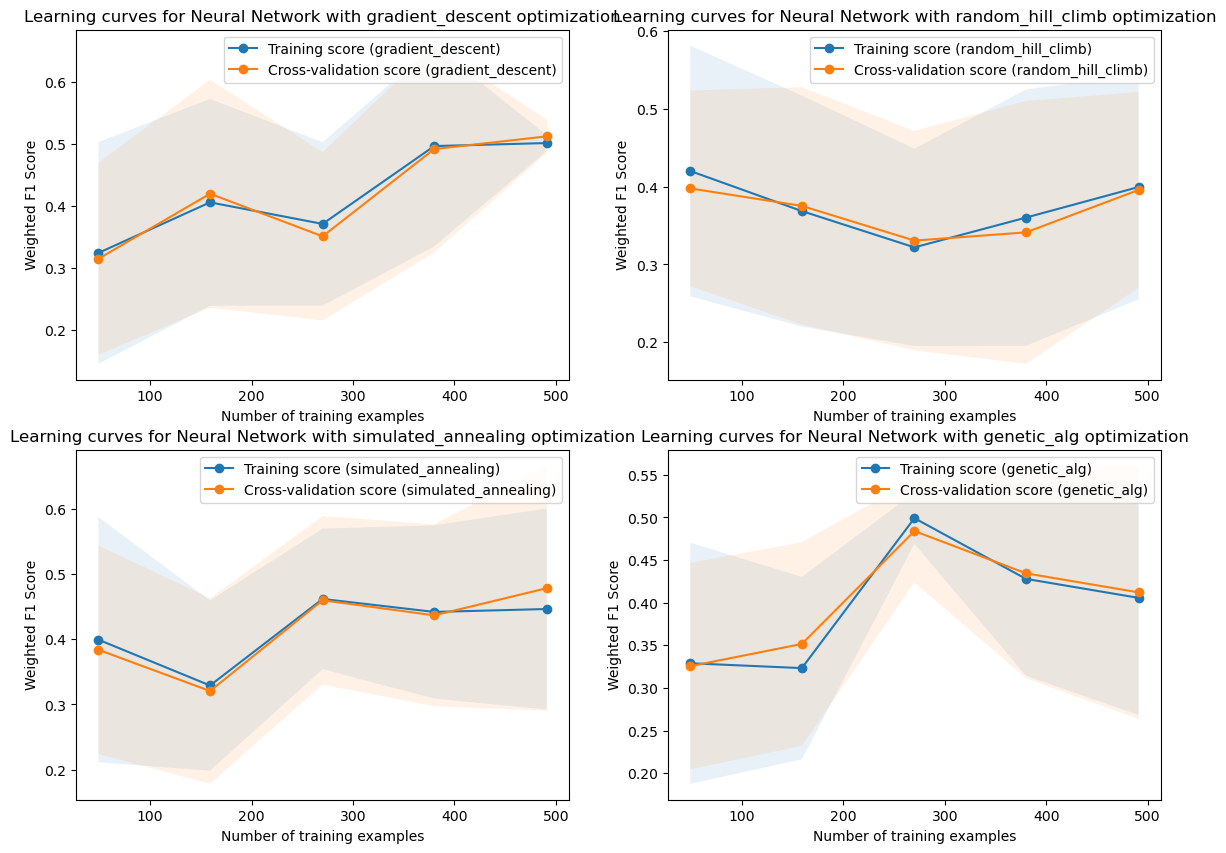

In [80]:
plot_learning_curve(models, X_train, y_train)

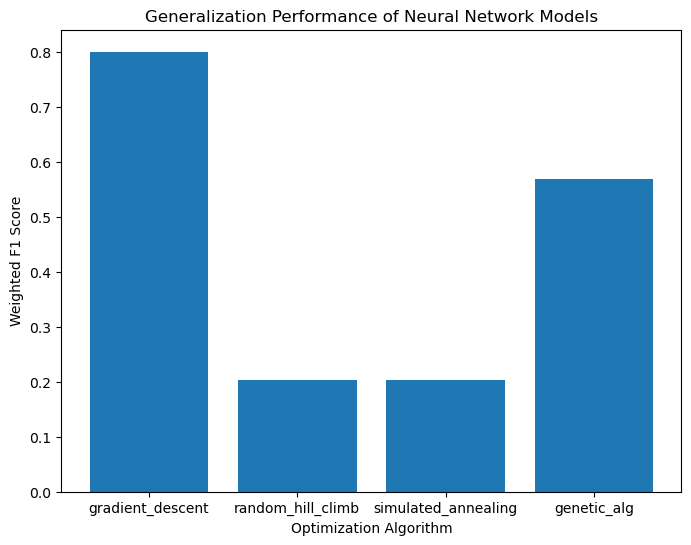

In [81]:
plot_generalization_performance(models,X_train, y_train, X_test, y_test)

In [7]:
!pip install mlrose_hiive
from mlrose_hiive import RHCRunner, SARunner, GARunner, MIMICRunner, NNGSRunner, NeuralNetwork

In [20]:
nn_model_rhc = NeuralNetwork(hidden_nodes=[30], activation='identity',
                                    algorithm='random_hill_climb', max_iters=1000,
                                    bias=True, is_classifier=True, learning_rate=0.0001,
                                    early_stopping=True, clip_max=5, max_attempts=100,
                                    random_state=123)
nn_model_sa = NeuralNetwork(hidden_nodes=[30], activation='identity',
                                   algorithm='simulated_annealing', max_iters=1000,
                                   bias=True, is_classifier=True, learning_rate=0.0001,
                                   early_stopping=True, clip_max=5, max_attempts=100,
                                   random_state=123)
nn_model_ga = NeuralNetwork(hidden_nodes=[30], activation='identity',
                                   algorithm='genetic_alg', max_iters=1000,
                                   bias=True, is_classifier=True, learning_rate=0.0001,
                                   early_stopping=True, clip_max=5, max_attempts=100,
                                   random_state=123)

In [21]:
def find_best_curve_run(run_curves):
    
    # find out which input state achieved the best fitness in the fewest fitness evaluations.
    best_fitness = run_curves['Fitness'].min()
    best_runs = run_curves[run_curves['Fitness'] == best_fitness]
    minimum_evaluations = best_runs['FEvals'].min()
    best_curve_run = best_runs[best_runs['FEvals'] == minimum_evaluations]
    
    return best_curve_run

In [22]:
grid_search_parameters = {
    'max_iters': [1000],                          # nn params
    'learning_rate': [1e-1, 1e-2],                       # nn params
    'activation': [mlrose_hiive.identity],            # nn params
    'restarts': [10],                             # rhc params
}

nnr = NNGSRunner(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    experiment_name='nn_exp_sgd',
    algorithm=mlrose_hiive.algorithms.gradient_descent,
    grid_search_parameters=grid_search_parameters,
    iteration_list=[1, 10, 50, 100, 500, 1000],
    hidden_layer_sizes=[[2]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=13,
    output_directory=None
)


gd_run_stats_df, gd_curves_df, gd_cv_results_df, gd_grid_search_cv = nnr.run()

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [23]:
grid_search_parameters = {
    'max_iters': [1000],                          # nn params
    'learning_rate': [1e-1, 1e-2],                       # nn params
    'activation': [mlrose_hiive.identity],            # nn params
    'restarts': [10],                             # rhc params
}

nnr = NNGSRunner(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    experiment_name='nn_exp_rhc',
    algorithm=mlrose_hiive.algorithms.rhc.random_hill_climb,
    grid_search_parameters=grid_search_parameters,
    iteration_list=[1, 10, 50, 100, 500, 1000],
    hidden_layer_sizes=[[2]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=13,
    output_directory=None
)


rhc_run_stats_df, rhc_curves_df, rhc_cv_results_df, rhc_grid_search_cv = nnr.run()

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [24]:
grid_search_parameters = {
    'max_iters': [1000],                          # nn params
    'learning_rate': [1e-1, 1e-2],                       # nn params
    'activation': [mlrose_hiive.identity],            # nn params
    'restarts': [10],                             # rhc params
}

nnr = NNGSRunner(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    experiment_name='nn_exp_sa',
    algorithm=mlrose_hiive.algorithms.simulated_annealing,
    grid_search_parameters=grid_search_parameters,
    iteration_list=[1, 10, 50, 100, 500, 1000],
    hidden_layer_sizes=[[2]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=13,
    output_directory=None
)


sa_run_stats_df, sa_curves_df, sa_cv_results_df, sa_grid_search_cv = nnr.run()

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [25]:
grid_search_parameters = {
    'max_iters': [1000],                          # nn params
    'learning_rate': [1e-1, 1e-2],                       # nn params
    'activation': [mlrose_hiive.identity],            # nn params
    'restarts': [10],                             # rhc params
}

nnr = NNGSRunner(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    experiment_name='nn_exp_ga',
    algorithm=mlrose_hiive.algorithms.genetic_alg,
    grid_search_parameters=grid_search_parameters,
    iteration_list=[1, 10, 50, 100, 500, 1000],
    hidden_layer_sizes=[[2]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=13,
    output_directory=None
)


ga_run_stats_df, ga_curves_df, ga_cv_results_df, ga_grid_search_cv = nnr.run()

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [26]:
best_rhc_run_curves = find_best_curve_run(rhc_curves_df)
best_restart = best_rhc_run_curves['current_restart'].iloc()[0]
best_rhc_run_stats = rhc_run_stats_df[(rhc_run_stats_df['current_restart'] == best_restart)]

In [27]:
sa_run_stats_df['Algorithm'] = 'SA'
ga_run_stats_df['Algorithm'] = 'GA'
best_rhc_run_stats['Algorithm'] = 'RHC'

In [28]:
result = pd.concat([sa_run_stats_df, ga_run_stats_df, best_rhc_run_stats], ignore_index=True)

In [29]:
! pip install plotly
import plotly.express as px

In [32]:
px.line(result, 
        x="Iteration", 
        y="Fitness", 
        color="Algorithm", 
        title="NN Fitness Score")

In [83]:
px.line(result, 
        x="Iteration", 
        y="Time", 
        color="Algorithm", 
        title="NN Fitness Score")